In [90]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])  # first 8 words

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [132]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [133]:
block_size = 8

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 8]) torch.Size([182437])
torch.Size([22781, 8]) torch.Size([22781])
torch.Size([22928, 8]) torch.Size([22928])


In [134]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[i.item()] for i in x), '->', itos[y.item()])

........ -> t
.......t -> a
......ta -> u
.....tau -> r
....taur -> e
...taure -> n
..tauren -> .
........ -> s
.......s -> u
......su -> l
.....sul -> e
....sule -> m
...sulem -> a
..sulema -> n
.suleman -> .
........ -> z
.......z -> e
......ze -> r
.....zer -> e
....zere -> n


In [135]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running "momentum average")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calc forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True, unbiased=False)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim)) 

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [127]:
torch.manual_seed(42)

In [147]:
n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in the model
for p in parameters:
    p.requires_grad = True

76579


In [137]:
ix = torch.randint(0, Xtr.shape[0], (4,)) 
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 11, 18,  9, 19],
        [ 0,  0,  5, 22,  5, 12,  5,  5],
        [ 0,  1,  4, 18,  9,  1, 14, 14],
        [ 0,  0,  0,  0,  0, 13,  3, 11]])

In [141]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [120]:
e = torch.randn(32,4,68)
emean = e.mean((0,1), keepdim=True)
evar = e.var((0,1), keepdim=True)
ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([32, 4, 68])

In [140]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch contruction
    ix = torch.randint(0, Xtr.shape[0],(batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  
     
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if  i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())




      0/ 200000: 3.2888
  10000/ 200000: 2.5562
  20000/ 200000: 1.9664
  30000/ 200000: 2.1100
  40000/ 200000: 1.8933
  50000/ 200000: 2.7748
  60000/ 200000: 1.7674
  70000/ 200000: 2.3314
  80000/ 200000: 1.9370
  90000/ 200000: 2.1571
 100000/ 200000: 1.7530
 110000/ 200000: 2.1913
 120000/ 200000: 1.9991
 130000/ 200000: 2.3920
 140000/ 200000: 1.7079
 150000/ 200000: 2.1578
 160000/ 200000: 1.7812
 170000/ 200000: 2.0225
 180000/ 200000: 2.0699
 190000/ 200000: 2.0253


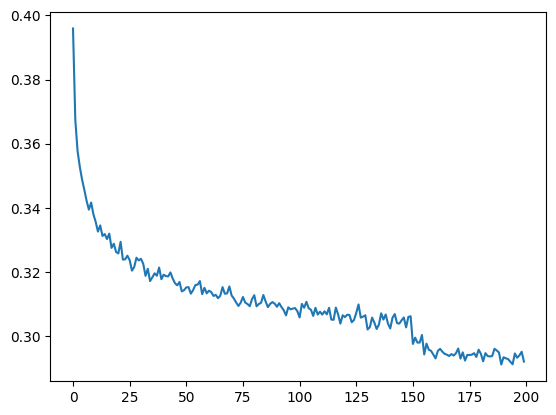

In [113]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [145]:
for layer in model.layers:
    layer.training = False

In [146]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')
split_loss('train')
split_loss('val')

train loss: 1.9134259223937988
val loss: 2.031853675842285


In [108]:
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

daven.
alaib.
kison.
estin.
lanica.
zahis.
vali.
emiana.
sabdes.
dearissa.
abshni.
rionna.
evinah.
cabreda.
meyaqa.
maida.
sydee.
waylesze.
lazara.
tilman.
